# 1 - Building and saving deep learning models
In this notebook all the deep learning models will be built and persisted.

## Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import pathlib

# sets the path to the home directory of this repository so other modules can be imported. 
root_path = os.path.split(os.getcwd())[0]
assert root_path.endswith("mask-detection"), "The root path does not end with mask-detection: " + root_path 
sys.path.insert(0, root_path)

# set the seed for reproducible results.
np.random.seed(0)
tf.random.set_seed(0)

# GPU settings
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

2.3.0


In [2]:
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2

In [3]:
# Facemask detection dataset
from datasets.facemask_dataset import FacemaskDataset
batch_size = 64
detection_ds_path = pathlib.Path(root_path + '/data/facemask-dataset')
detection_ds = FacemaskDataset(detection_ds_path, batch_size, 200, 200, True, train_percentage, validation_percentage, test_percentage)

train: 36 validation: 12 test: 12


In [ ]:
# Facemask judge dataset
from datasets.facemask_net_dataset import FacemaskNetDataset
batch_size = 256
judge_ds_path = pathlib.Path('C:\Facemask-dataset')
judge_ds = FacemaskNetDataset(judge_ds_path, batch_size, train_percentage, validation_percentage, test_percentage)

## Building models

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

### Facemask detection CNN
A CNN which will be used for face mask detection

In [5]:
detection_model = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

detection_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=['acc'])

In [6]:
detection_model.build(input_shape=(batch_size, 200, 200, 3))
detection_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (64, 200, 200, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 198, 198, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (64, 99, 99, 32)          0         
_________________________________________________________________
dropout (Dropout)            (64, 99, 99, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 97, 97, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (64, 48, 48, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (64, 48, 48, 32)          0

In [7]:
# Add a callback for earlystopping
callbacks = [EarlyStopping(patience=10, monitor='val_loss')]

detection_history = detection_model.fit(
    x=detection_ds.train_ds,
    validation_data=detection_ds.val_ds,
    epochs=100,
    validation_steps=detection_ds.val_size,
    steps_per_epoch=detection_ds.train_size,
    callbacks=callbacks
)

Epoch 1/100
36/36 [==============================] - 32s 891ms/step - loss: 0.6929 - acc: 0.5039 - val_loss: 0.6926 - val_acc: 0.4753
Epoch 2/100
36/36 [==============================] - 2s 45ms/step - loss: 0.6898 - acc: 0.5486 - val_loss: 0.6857 - val_acc: 0.7266
Epoch 3/100
36/36 [==============================] - 2s 43ms/step - loss: 0.6802 - acc: 0.5751 - val_loss: 0.6705 - val_acc: 0.6315
Epoch 4/100
36/36 [==============================] - 2s 43ms/step - loss: 0.6580 - acc: 0.6254 - val_loss: 0.6381 - val_acc: 0.6888
Epoch 5/100
36/36 [==============================] - 2s 45ms/step - loss: 0.6185 - acc: 0.6957 - val_loss: 0.5845 - val_acc: 0.7617
Epoch 6/100
36/36 [==============================] - 2s 43ms/step - loss: 0.5643 - acc: 0.7361 - val_loss: 0.5225 - val_acc: 0.7826
Epoch 7/100
36/36 [==============================] - 2s 43ms/step - loss: 0.5093 - acc: 0.7721 - val_loss: 0.5078 - val_acc: 0.8034
Epoch 8/100
36/36 [==============================] - 2s 43ms/step - loss: 

### Facemask Judge CNN
A CNN which will be used for judging if a face mask is correctly worn

In [12]:
judge_model = tf.keras.Sequential([
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

judge_model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=['acc'])

In [13]:
callbacks = [EarlyStopping(patience=10, monitor='val_loss')]

judge_history = judge_model.fit(
    x=judge_ds.train_ds,
    validation_data=judge_ds.val_ds,
    epochs=100,
    validation_steps=judge_ds.val_size,
    steps_per_epoch=judge_ds.train_size,
    callbacks=callbacks
)

Epoch 1/100
308/308 [==============================] - 29s 94ms/step - loss: 0.1292 - acc: 0.9423 - val_loss: 0.0173 - val_acc: 0.9958
Epoch 2/100
308/308 [==============================] - 29s 94ms/step - loss: 0.0133 - acc: 0.9956 - val_loss: 0.0092 - val_acc: 0.9970
Epoch 3/100
308/308 [==============================] - 30s 96ms/step - loss: 0.0093 - acc: 0.9967 - val_loss: 0.0068 - val_acc: 0.9976
Epoch 4/100
308/308 [==============================] - 28s 92ms/step - loss: 0.0083 - acc: 0.9970 - val_loss: 0.0060 - val_acc: 0.9977
Epoch 5/100
308/308 [==============================] - 28s 92ms/step - loss: 0.0070 - acc: 0.9974 - val_loss: 0.0055 - val_acc: 0.9980
Epoch 6/100
308/308 [==============================] - 28s 92ms/step - loss: 0.0053 - acc: 0.9980 - val_loss: 0.0046 - val_acc: 0.9984
Epoch 7/100
308/308 [==============================] - 28s 92ms/step - loss: 0.0052 - acc: 0.9980 - val_loss: 0.0046 - val_acc: 0.9983
Epoch 8/100
308/308 [==============================] - 

## Visualise training history

In [8]:
def visualise_results(history):
    def plot_graph(history, metric, label):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric], '')
        plt.xlabel("epochs", fontsize=15)
        plt.ylabel(label, fontsize=15)
        plt.legend([f'training {label}', f'validation {label}'])

    fig = plt.figure(figsize=(16,8))
    fig.suptitle("Training metrics", fontsize=20)
    plt.subplot(1,2,1)
    plot_graph(history, 'acc', 'accuracy')
    plt.ylim(None,1)
    plt.subplot(1,2,2)
    plot_graph(history, 'loss', 'loss')
    plt.ylim(0,None)

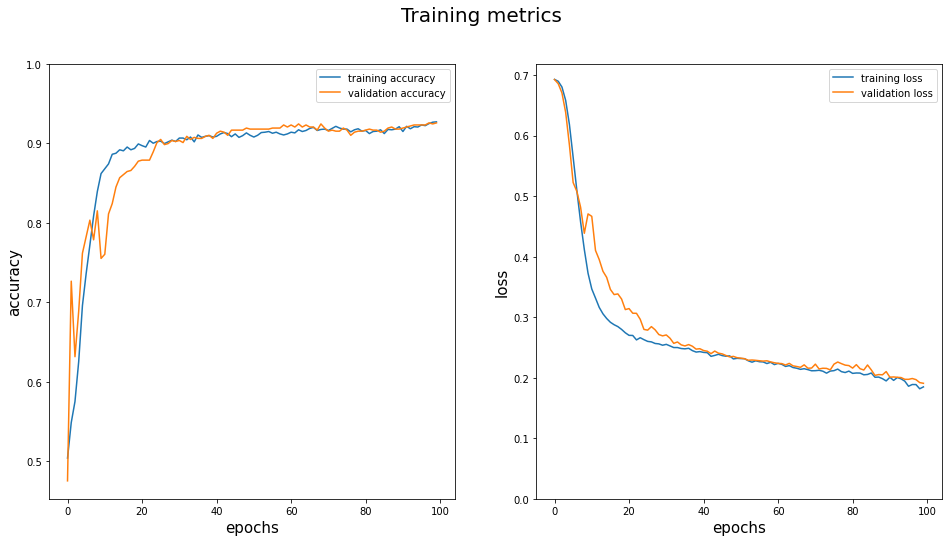

In [9]:
visualise_results(detection_history)

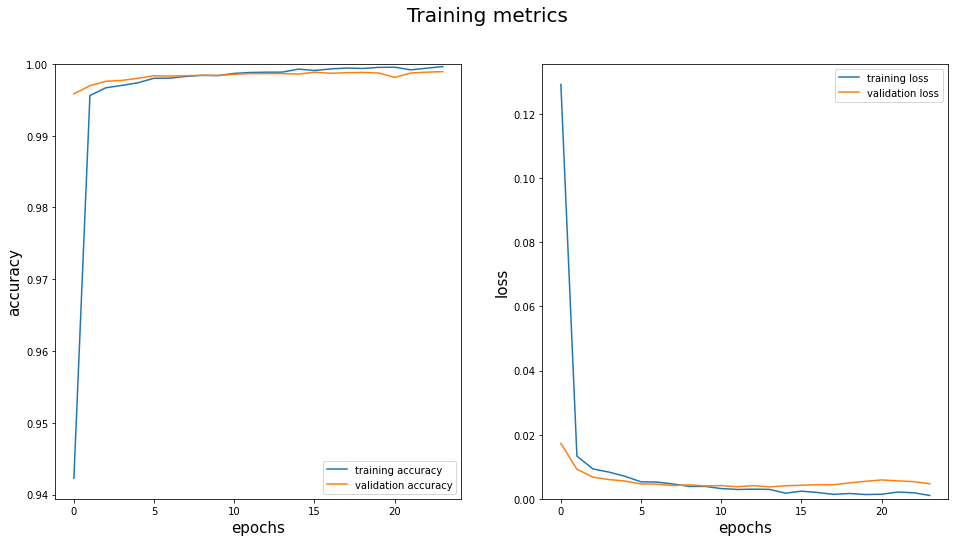

In [16]:
visualise_results(judge_history)

## Saving models

In [10]:
detection_model.save(root_path + '/models/detection_cnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: c:\Users\mario\source\repos\mask-detection/models/detection_cnn\assets


In [ ]:
judge_model.save(root_path + '/models/judge_cnn')